In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import pathlib
from lb2jpsil import lorentz
import random
from typing import Tuple
from scipy import optimize, integrate, stats
import time
import ROOT

Welcome to JupyROOT 6.24/06


In [2]:
#ROOT.RooClassFactory.makePdf("AngularDistribution", "ctheta,phi,sx,sz,alpha", "",
#                             "1+ alpha * (sx * sqrt(1-pow(ctheta,2)) * cos(phi) + sz * ctheta)"
#                            )

In [3]:
ROOT.gSystem.Load('libAngularDistribution.so')

0


RooFit v3.60 -- Developed by Wouter Verkerke and David Kirkby 
                Copyright (C) 2000-2013 NIKHEF, University of California & Stanford University
                All rights reserved, please read http://roofit.sourceforge.net/license.txt



In [4]:
ctheta = ROOT.RooRealVar("ctheta", "ctheta", 0.5, -.9, .9)
phi = ROOT.RooRealVar("phi", "phi", 0.1, -np.pi+1., np.pi-1.)
alpha = ROOT.RooFit.RooConst( 0.732 )
sx = ROOT.RooRealVar('sx','sx',0.5,-1,1)
sz = ROOT.RooRealVar('sz','sz',1.,-1,1)

In [5]:
pdf = ROOT.AngularDistribution("pdf", "pdf", ctheta, phi, sx, sz, alpha)

In [6]:
pdf.evaluate()

1.6813817915447689

In [7]:
sigma_theta = ROOT.RooFit.RooConst(0.097)
mu_theta = ROOT.RooFit.RooConst(0.)

In [8]:
theta_gauss = ROOT.RooGaussian("theta_gauss", "theta_gauss", ctheta, mu_theta, sigma_theta)

In [9]:
sigma_phi = ROOT.RooFit.RooConst(0.332)
mu_phi = ROOT.RooFit.RooConst(0.)

In [10]:
phi_gauss = ROOT.RooGaussian("phi_gauss", "phi_gauss", phi, mu_phi, sigma_phi)

In [11]:
theta_convoluted = ROOT.RooFFTConvPdf("theta_convoluted", "theta_convoluted", ctheta, pdf, theta_gauss)

[#1] INFO:Caching -- Changing internal binning of variable 'ctheta' in FFT 'theta_convoluted' from 100 to 930 to improve the precision of the numerical FFT. This can be done manually by setting an additional binning named 'cache'.


In [12]:
phi_theta_convoluted = ROOT.RooFFTConvPdf("phi_theta_convoluted", "phi_theta_convoluted", phi, theta_convoluted, phi_gauss)

[#1] INFO:Caching -- Changing internal binning of variable 'phi' in FFT 'phi_theta_convoluted' from 100 to 930 to improve the precision of the numerical FFT. This can be done manually by setting an additional binning named 'cache'.


In [13]:
data = theta_convoluted.generate(ctheta, 10000)
#data = phi_theta_convoluted.generate(ctheta, 10000)

[#1] INFO:Eval -- RooRealVar::setRange(ctheta) new range named 'refrange_fft_theta_convoluted' created with bounds [-0.9,0.9]
[#1] INFO:NumericIntegration -- RooRealIntegral::init(pdf_Int[ctheta]) using numeric integrator RooIntegrator1D to calculate Int(ctheta)
[#1] INFO:Caching -- RooAbsCachedPdf::getCache(theta_convoluted) creating new cache 0x8259390 with pdf pdf_CONV_theta_gauss_CACHE_Obs[ctheta]_NORM_ctheta for nset (ctheta) with code 0
[#1] INFO:Caching -- RooAbsCachedPdf::getCache(theta_convoluted) creating new cache 0x8316c50 with pdf pdf_CONV_theta_gauss_CACHE_Obs[ctheta]_NORM_ctheta for nset (ctheta) with code 0 from preexisting content.


In [14]:
data.mean(ctheta)

0.14076921654677324

In [15]:
dir(theta_convoluted)

['AClean',
 'ADirty',
 'AbstractMethod',
 'Activate',
 'Always',
 'AppendPad',
 'Auto',
 'Browse',
 'CanBeExtended',
 'CanNotBeExtended',
 'CheckedHash',
 'Class',
 'ClassName',
 'Class_Name',
 'Class_Version',
 'Clear',
 'Clone',
 'CollectErrors',
 'Compare',
 'ConfigChange',
 'Copy',
 'CountErrors',
 'DeActivate',
 'DeclFileLine',
 'DeclFileName',
 'Delete',
 'Dictionary',
 'DistancetoPrimitive',
 'Draw',
 'DrawClass',
 'DrawClone',
 'Dump',
 'Error',
 'Execute',
 'ExecuteEvent',
 'Extend',
 'Fatal',
 'FillBuffer',
 'FindObject',
 'Flat',
 'GetDrawOption',
 'GetDtorOnly',
 'GetIconName',
 'GetName',
 'GetObjectInfo',
 'GetObjectStat',
 'GetOption',
 'GetTitle',
 'GetUniqueID',
 'HandleTimer',
 'HasInconsistentHash',
 'Hash',
 'Ignore',
 'ImplFileLine',
 'ImplFileName',
 'Info',
 'InheritsFrom',
 'Inspect',
 'InvertBit',
 'IsA',
 'IsEqual',
 'IsFolder',
 'IsOnHeap',
 'IsSortable',
 'IsZombie',
 'MayNotUse',
 'Mirror',
 'MustBeExtended',
 'Never',
 'NotAdvised',
 'Notify',
 'NumEvent',

In [16]:
c1 = ROOT.TCanvas

In [17]:
hist = data.createHistogram("", ctheta)

In [18]:
hist.Draw()

Info in <TCanvas::MakeDefCanvas>:  created default TCanvas with name c1


In [19]:
data.write("test.dat")

False

[#1] INFO:DataHandling -- RooDataSet::write(theta_convolutedData) writing ASCII file test.dat


In [20]:
df_data = pd.read_csv('test.dat', sep="\n", header=None)

In [21]:
df_data

,0
0,-0.173018
1,0.545387
2,0.518671
3,-0.328837
4,0.486767
...,...
9995,0.143891
9996,-0.031188
9997,0.083215
9998,-0.068673


In [22]:
df_data.min()

0   -0.899993
dtype: float64

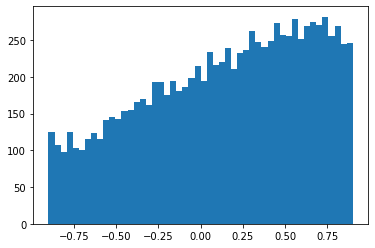

In [23]:
plt.hist(df_data,bins=50)
plt.show()

This finds the value in 1D.

In [24]:
xframe = ctheta.frame()

In [25]:
theta_convoluted.plotOn(xframe, ROOT.RooFit.Name("theta_convoluted"))

[#1] INFO:Caching -- RooAbsCachedPdf::getCache(theta_convoluted) creating new cache 0x8a6b0b0 with pdf pdf_CONV_theta_gauss_CACHE_Obs[ctheta]_NORM_ctheta for nset (ctheta) with code 0 from preexisting content.


In [26]:
func = xframe.findObject("theta_convoluted")

In [27]:
func.Eval(0.)

0.010460765496068752